In [62]:
import numpy as np
import pandas as pd
from prince import FAMD
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, hp, tpe, Trials, space_eval
from quantile_forest import RandomForestQuantileRegressor
from sklearn.model_selection import GridSearchCV

In [66]:
df = pd.read_csv('data/possum.csv')
df = df.drop('case', axis=1)

In [67]:
numerical_col = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats

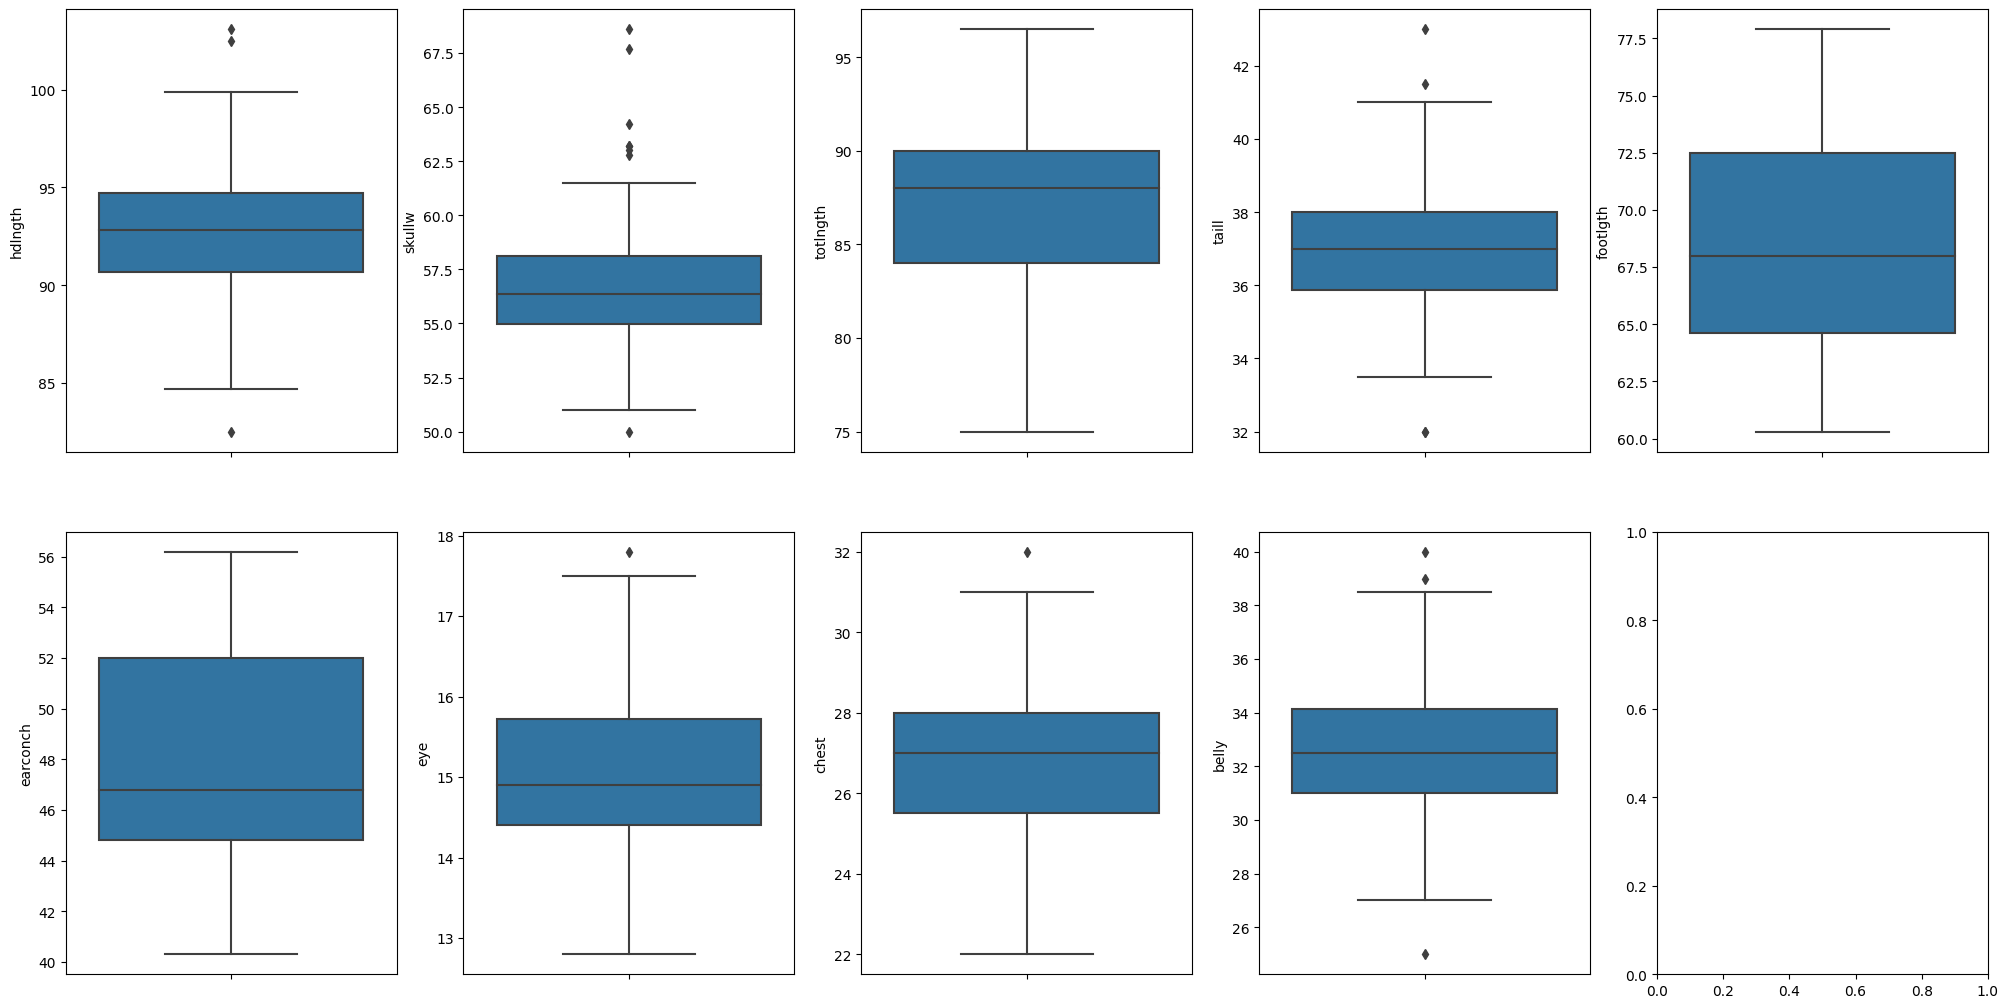

In [69]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df[numerical_col].items():
    sns.boxplot(y=k, data=df[numerical_col], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


/var/folders/sl/6pfddh5x4ljcbvrtvkcnqglc0000gn/T/ipykernel_7797/863632027.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(v, ax=axs[index], kde_kws={'bw':0.1})
/opt/homebrew/lib/python3.10/site-packages/seaborn/distributions.py:2511: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/var/folders/sl/6pfddh5x4ljcbvrtvkcnqglc0000gn/T/ipykernel_7797/863632027.py:5: UserWarning: 

`distplot` is a deprecated 

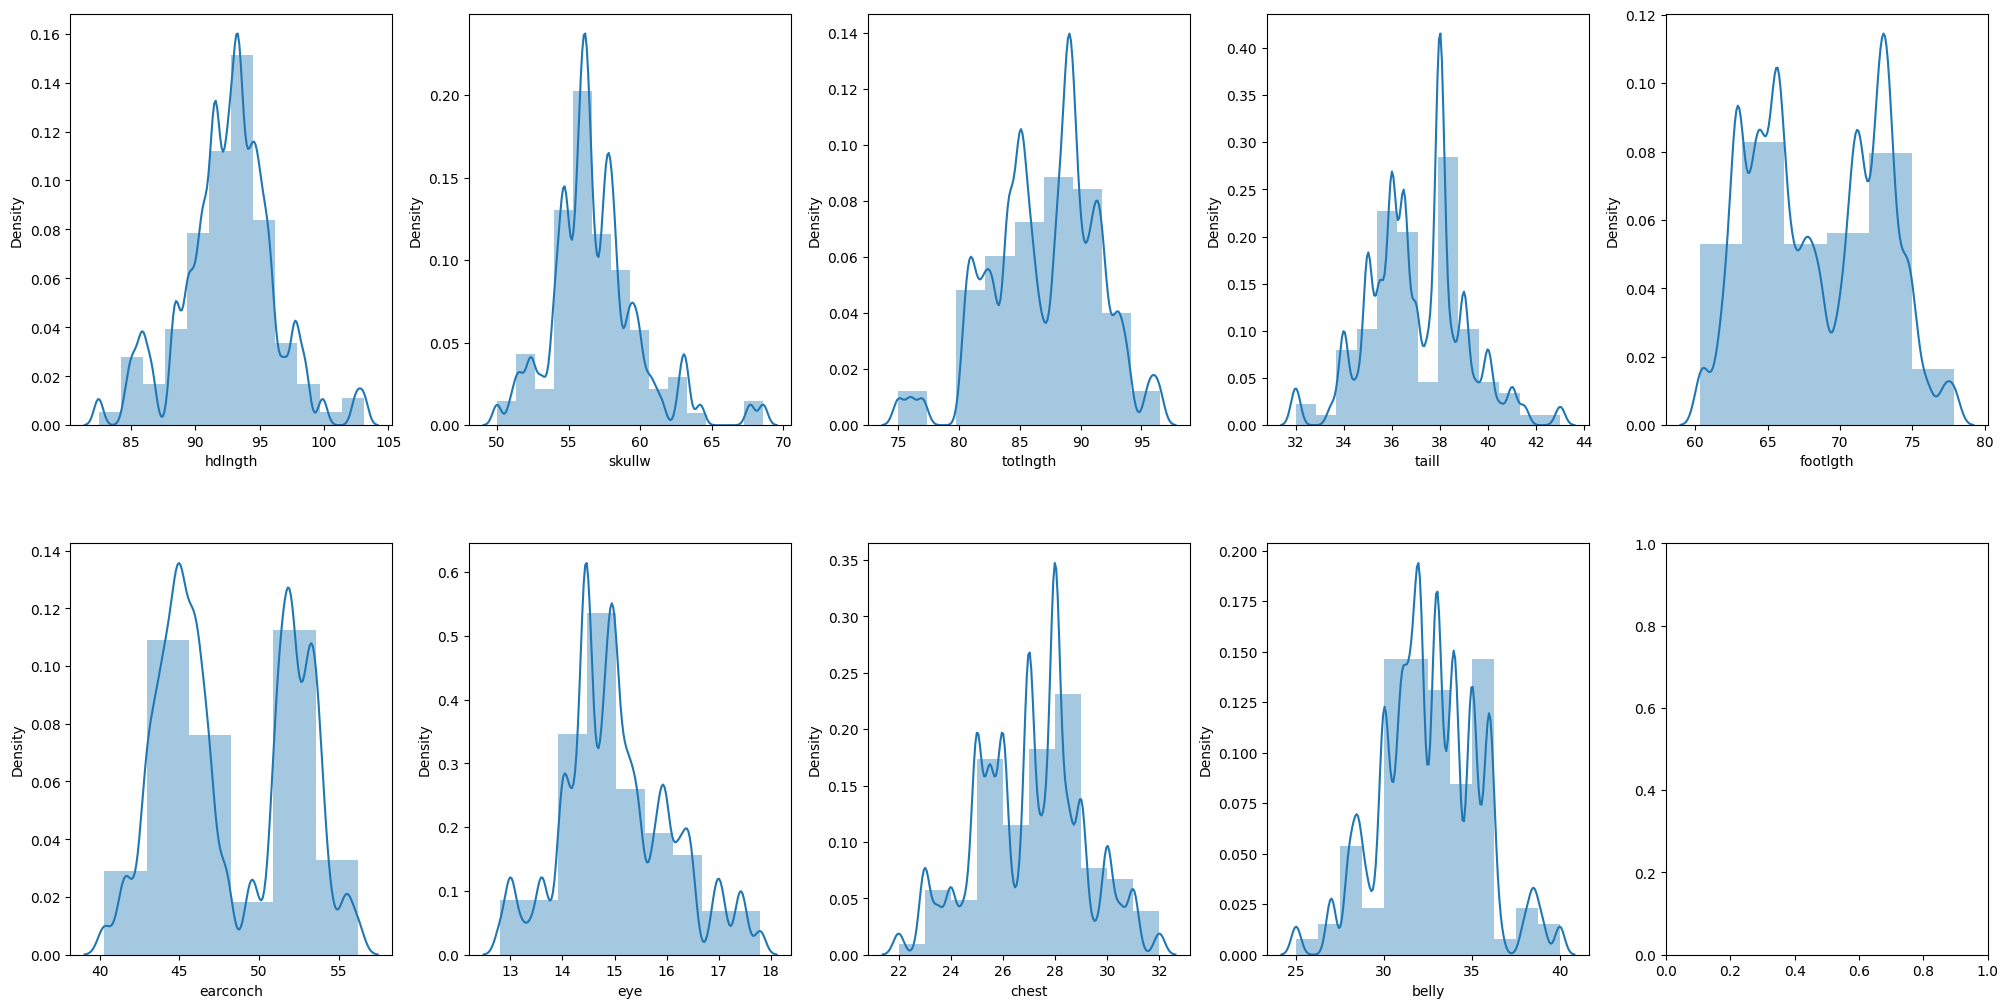

In [70]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df[numerical_col].items():
    sns.distplot(v, ax=axs[index], kde_kws={'bw':0.1})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


In [71]:
from dython.nominal import associations

In [72]:
corr = associations(df, nominal_columns='auto', compute_only=True)

<Axes: >

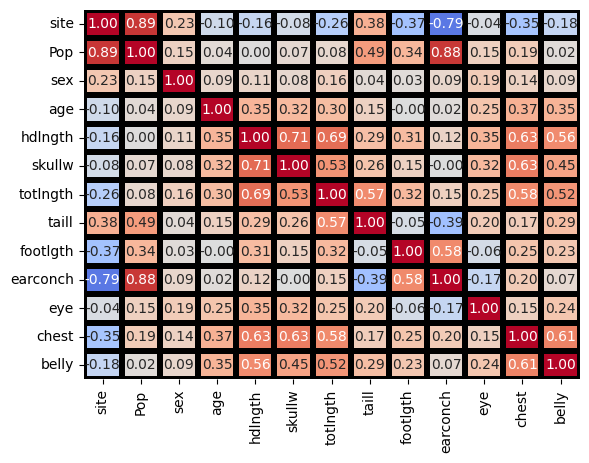

In [73]:
sns.heatmap(corr['corr'], annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=3, linecolor='black', cbar=False)

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from quantile_forest import RandomForestQuantileRegressor

In [75]:
col_to_encod = ['site', 'Pop', 'sex']

In [76]:
df = pd.get_dummies(df, columns=col_to_encod).astype('float32')

In [77]:
df = df.astype('float32')

In [78]:
df = df.dropna()
df

,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,...,site_2,site_3,site_4,site_5,site_6,site_7,Pop_Vic,Pop_other,sex_f,sex_m
0,8.0,94.099998,60.400002,89.0,36.0,74.500000,54.500000,15.2,28.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,6.0,92.500000,57.599998,91.5,36.5,72.500000,51.200001,16.0,28.5,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,6.0,94.000000,60.000000,95.5,39.0,75.400002,51.900002,15.5,30.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,6.0,93.199997,57.099998,92.0,38.0,76.099998,52.200001,15.2,28.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2.0,91.500000,56.299999,85.5,36.0,71.000000,53.200001,15.1,28.5,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1.0,89.500000,56.000000,81.5,36.5,66.000000,46.799999,14.8,23.0,27.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
100,1.0,88.599998,54.700001,82.5,39.0,64.400002,48.000000,14.0,25.0,33.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
101,6.0,92.400002,55.000000,89.0,38.0,63.500000,45.400002,13.0,25.0,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
102,4.0,91.500000,55.200001,82.5,36.5,62.900002,45.900002,15.4,25.0,29.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [79]:
X = df.drop('age', axis=1)
y = df['age']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [80]:
def hyperOptimizerRF(X,y,iterations,cv):
    #on définit l'espace des paramètres (=les valeurs possibles pur chaque paramètre)
    hyper_space = {'max_depth': hp.choice('max_depth',[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]),
    'max_features': hp.choice('max_features', range(1,len(list(X.columns))-1)),
    'n_estimators': hp.choice('n_estimators', range(100,1000)),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'min_samples_split' : hp.choice('min_samples_split',[2,3,4,5,6,7,8,9,10,11,12,13,14,15]),
    'min_samples_leaf' : hp.choice('min_samples_leaf',[1,2,3,4,5,6,7,8,9,10])}

    def evaluate(params, X, y):
        est = RandomForestRegressor(n_jobs=-1)       #on créé un modèle qui sert d'estimateur
        est.set_params(**params)        #on applique au modèle les paramètres entrés
        #On fait une cross validation et on calcule les scores au cours de cette cv (ici, l'erreur mean_absolute_error)
        scores = cross_val_score(estimator=est, X=X, y=y, scoring='neg_mean_absolute_error', cv=cv, error_score=1000)
        score = np.mean(scores)         #on fait la moyenne des scores pour obtenir le score global
        return score
    
    hyperopt_objective = lambda params: (-1.0)*evaluate(params, X, y)       #fonction qui retourne le score correspondant aux paramètres (-1 car le score de base est négatif)
    trials = Trials()   #on créé des barres pour afficher la progression temporelle de la résolution
    best_vals = fmin(hyperopt_objective, space=hyper_space,algo=tpe.suggest, max_evals=iterations, trials=trials,rstate=np.random.default_rng(2018))       #on cherche les valeurs qui minimisent la fonction qui minimise le score sur l'espace des paramètres, on fait le nombre d'itérations demandé
    best_params = space_eval(hyper_space, best_vals)        #on cherche les paramètres correspondants dans l'espace des paramètres
    return best_params

In [82]:
params = hyperOptimizerRF(X, y, 100, 5)

100%|██████████| 100/100 [01:13<00:00,  1.36trial/s, best loss: 1.3364477315937304]


In [83]:
params

{'bootstrap': False,
 'max_depth': 1,
 'max_features': 16,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 992}

In [84]:
model = RandomForestRegressor(**params)

In [85]:
model.fit(X,y )

RandomForestRegressor(bootstrap=False, max_depth=1, max_features=16,
                      min_samples_split=5, n_estimators=992)

In [87]:
pred = model.predict(X)

In [88]:
# score 
mean_absolute_error(y, pred)

1.2892344120872206

In [89]:
import pickle

In [90]:
pickle.dump(model, open('saved_models/model.pkl', 'wb'))

In [54]:
df.to_csv('data/df.csv', index=False)

In [55]:
pd.read_csv('data/df.csv')

,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,...,site_2,site_3,site_4,site_5,site_6,site_7,Pop_Vic,Pop_other,sex_f,sex_m
0,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.0,89.5,56.0,81.5,36.5,66.0,46.8,14.8,23.0,27.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
97,1.0,88.6,54.7,82.5,39.0,64.4,48.0,14.0,25.0,33.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
98,6.0,92.4,55.0,89.0,38.0,63.5,45.4,13.0,25.0,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
99,4.0,91.5,55.2,82.5,36.5,62.9,45.9,15.4,25.0,29.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [91]:
from quantile_forest import RandomForestQuantileRegressor

In [92]:
model2 = RandomForestQuantileRegressor(**params)

In [93]:
model2.fit(X, y)

RandomForestQuantileRegressor(bootstrap=False, max_depth=1, max_features=16,
                              min_samples_split=5, n_estimators=992)

In [94]:
pickle.dump(model2, open('saved_models/qrf.pkl', 'wb'))